In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting,ARIMA
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
import statsmodels

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data
We filter period of Oct 2011 - Oct 2012 for the case study

In [3]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)
data.index = data.index.astype('datetime64[ns]')
data_subset = data.loc['2011-10-01':'2016-05-08'].reset_index().groupby('item_id').resample('W-Mon', on='date').sum()
data_subset['sell_price'] = data.loc['2012-01-02':'2015-01-04'].reset_index().groupby('item_id').resample('W-Mon', on='date').max()['sell_price']

In [4]:
data_subset.reset_index(inplace=True)

In [5]:
data_subset.head(5)

item_id       date  sell_price  wday  snap_CA  snap_TX  snap_WI  \
0  FOODS_1_004 2012-03-05        1.78   6.0      3.0      2.0      2.0   
1  FOODS_1_004 2012-03-12        1.78  28.0      5.0      5.0      5.0   
2  FOODS_1_004 2012-03-19        1.78  28.0      0.0      2.0      2.0   
3  FOODS_1_004 2012-03-26        1.78  28.0      0.0      0.0      0.0   
4  FOODS_1_004 2012-04-02        1.78  28.0      2.0      1.0      1.0   

    sales  special_events      sin_wday      cos_wday  
0     0.0             0.0  2.190643e+00 -5.000000e-01  
1   954.0             1.0 -2.220446e-16 -2.220446e-16  
2  1286.0             1.0 -2.220446e-16 -2.220446e-16  
3  1153.0             0.0 -2.220446e-16 -2.220446e-16  
4  1052.0             0.0 -2.220446e-16 -2.220446e-16

Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [139]:
top_items = data_subset.groupby('item_id').sum().sort_values(by='sales').index[-6:-1]

alt.data_transformers.disable_max_rows()

alt.Chart(data_subset.loc[data_subset.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

alt.Chart(...)

In [140]:
def get_input_item(item_id='FOODS_3_555'):
    item = data_subset.loc[data_subset.item_id.isin([item_id])]
    item.loc[item.sales<=0,'sales'] = item.sales.median()
    return item

len(get_input_item(item_id='FOODS_3_555'))

241

In [141]:
sm.graphics.tsa.plot_pacf(get_input_item(item_id='FOODS_3_252').sales,lags=100)

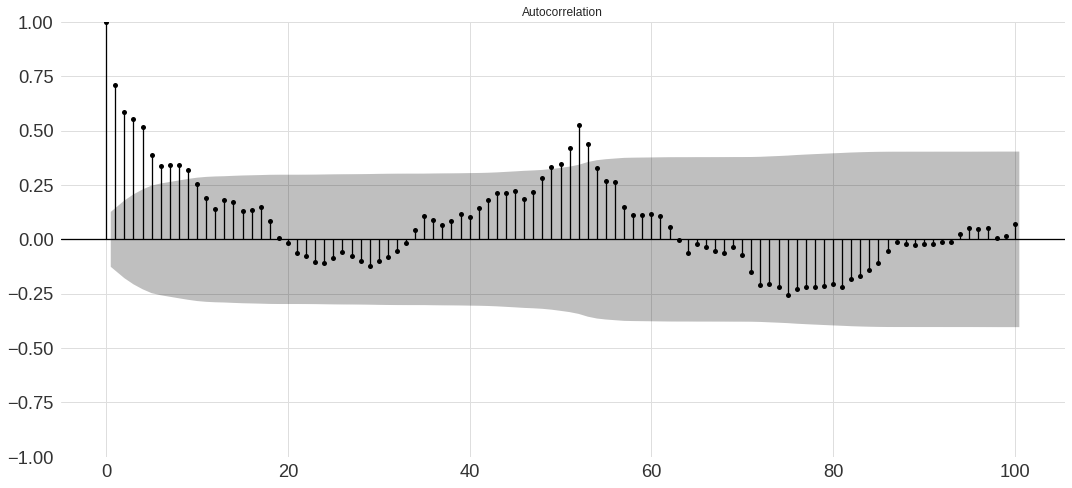

In [142]:
sm.graphics.tsa.plot_acf(get_input_item(item_id='FOODS_3_586').sales,lags=100)

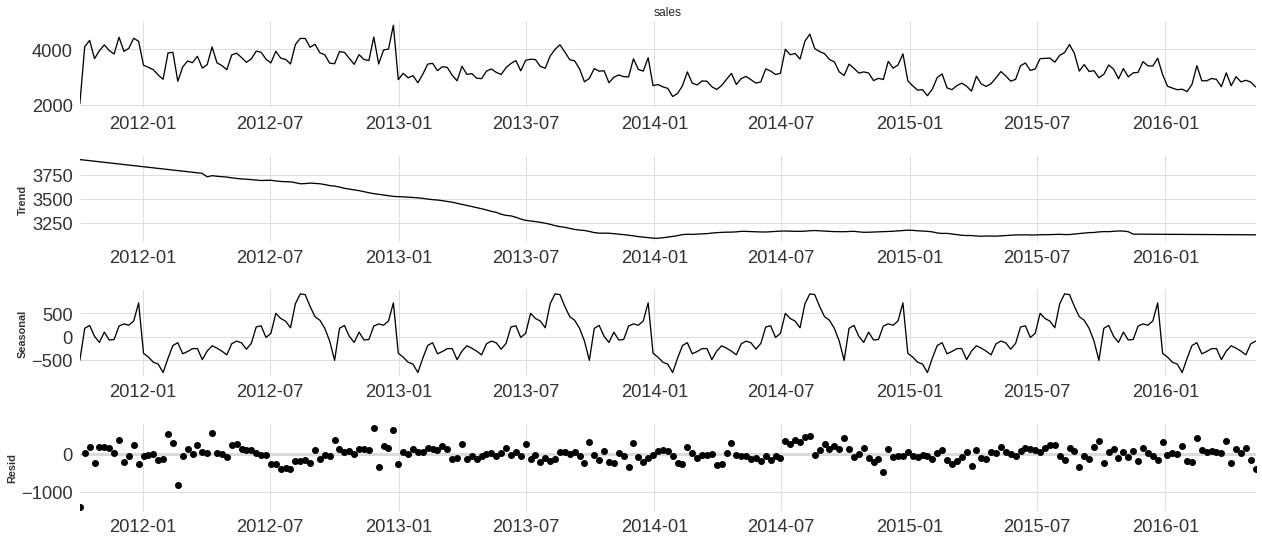

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(get_input_item(item_id='FOODS_3_586').set_index('date').sales, model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

## Building prediction models

In [144]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.5, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates,
                             model_display_name, 
                             future_covs=False):

    horizon = 1
    
    if future_covs == False:
        print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              start=60, 
                                              last_points_only=False, 
                                              overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              future_covariates=future_covariates,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df#.iloc[:-(horizon*2)]
    else:
        return res_df
    #return res_df

In [145]:
"""input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), value_cols=['sales'])
future = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])

input_train, _ = input_timeseries.split_before(0.33)

lgbm_model_cov = LightGBMModel(lags=[-1,-2,-52],
                                   lags_future_covariates=[0,1],
                                   boosting_type='gbdt', 
                                   num_leaves=20, 
                                   max_depth= -1, 
                                   learning_rate=0.01, 
                                   n_estimators=300)
    
lgbm_model_cov.fit(input_train,
                       future_covariates=future)

get_historical_forecasts(lgbm_model_cov,
                         input_timeseries=input_timeseries,
                         model_display_name = naive_model_weekly,
                         future_covariates=future,
                         future_covs = True)"""

"input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), value_cols=['sales'])\nfuture = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), \n                                       value_cols=['sin_wday','cos_wday','special_events'])\n\ninput_train, _ = input_timeseries.split_before(0.33)\n\nlgbm_model_cov = LightGBMModel(lags=[-1,-2,-52],\n                                   lags_future_covariates=[0,1],\n                                   boosting_type='gbdt', \n                                   num_leaves=20, \n                                   max_depth= -1, \n                                   learning_rate=0.01, \n                                   n_estimators=300)\n    \nlgbm_model_cov.fit(input_train,\n                       future_covariates=future)\n\nget_historical_forecasts(lgbm_model_cov,\n                         input_timeseries=input_timeseries,\n                         model_display_name = naive_model_wee

In [146]:
 def create_forecast_for_item(itemid, lags = [-1,-2,-52],lags_future_covariates=[0,1]):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), value_cols=['sales'])

    future = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
    
    print(future)
    # We first set aside the first 33% as training series:
    input_train, _ = input_timeseries.split_before(0.33)

    naive_model_weekly = NaiveSeasonal(K=1)
    naive_model_weekly.fit(input_train)

    regr_model_lags =  RegressionModel(lags=lags)
    regr_model_lags.fit(input_train)

    #regr_model_cov = RegressionModel(lags=lags,
    #                                 lags_future_covariates=lags_future_covariates)
    #regr_model_cov.fit(input_train,future_covariates=future)

    lgbm_model_cov = LightGBMModel(lags=lags,
                                   lags_future_covariates=lags_future_covariates,
                                   boosting_type='gbdt', 
                                   num_leaves=5, 
                                   max_depth= 3, 
                                   learning_rate=0.01, 
                                   n_estimators=300)
    
    lgbm_model_cov.fit(input_train,
                       future_covariates=future)

    lgbm_model = LightGBMModel(lags=lags,
                               boosting_type='gbdt', 
                               num_leaves=5, 
                               max_depth= 3, 
                               learning_rate=0.1, 
                               n_estimators=300)
    
    lgbm_model.fit(input_train)
    
    rf_model = RandomForest(lags=lags,
                               max_depth= 10, 
                               n_estimators=100)
    
    rf_model.fit(input_train)
    
    theta_model =  Theta(2,
                         season_mode=SeasonalityMode.MULTIPLICATIVE)
    
    theta_model.fit(input_train)
    
    #fft_model =  FFT(nr_freqs_to_keep=7, 
    #                 required_matches=set(), 
    #                 trend='exp')

    #fft_model.fit(input_train)
    
    arima_model = ARIMA(p=3, d=0, q=2, seasonal_order=(0, 0, 0, 0), random_state=0)
    
    arima_model.fit(input_train)
    
    models = {'Naive weekly':[naive_model_weekly,False],
              'Regression':[regr_model_lags,False],
              #'RegressionModelCov':[regr_model_cov,True],
              #'LGBM_cov':[lgbm_model_cov,True],
              'LGBM':[lgbm_model,False],
              'RF':[rf_model,False],
              'Theta':[theta_model,False],
              'ARIMA':[arima_model,False]
             }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates=future,
                                                             future_covs = models[model][1]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [152]:
lags_by_item = {'FOODS_3_555':[-1,-2,-3,-52], 
                'FOODS_3_252':[-1,-2,-49,-52],
                'FOODS_3_586': [-1,-2,-52],
               'FOODS_3_694': [-1,-2,-52],
               'FOODS_3_714': [-1,-2,-52]}

optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item,lags_by_item[item],lags_future_covariates=[-1,-2,-52]) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


In [153]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data_subset.reset_index().set_index(['date','item_id'])['sales']
#fact.loc[:,'FOODS_3_090',:].head()

In [154]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data_subset.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [155]:
alt.Chart(optimization_df).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    tooltip=['model:N','prediction_date:T','value:Q'],
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

### Evaluation function for all item_ids

In [156]:
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        fact_index = df.loc[df.model=='Fact'].index
        
        #print(m, len(df.loc[df.model=='Fact','value']),len(df.loc[df.model==m,'value']))
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rRMSE'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rRMSE','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

model        rmse     rRMSE      item_id
0   Naive weekly  175.462829       1.0  FOODS_3_694
1     Regression  156.165124  0.890018  FOODS_3_694
2           LGBM  167.206654  0.952946  FOODS_3_694
3             RF  153.038121  0.872197  FOODS_3_694
4          Theta  162.852605  0.928132  FOODS_3_694
5          ARIMA  160.605961  0.915328  FOODS_3_694
6           Fact         0.0       0.0  FOODS_3_694
7   Naive weekly  182.412183       1.0  FOODS_3_714
8     Regression  155.263903  0.851171  FOODS_3_714
9           LGBM  208.676481  1.143983  FOODS_3_714
10            RF  164.821489  0.903566  FOODS_3_714
11         Theta  175.865436   0.96411  FOODS_3_714
12         ARIMA  166.309111  0.911722  FOODS_3_714
13          Fact         0.0       0.0  FOODS_3_714
14  Naive weekly  198.212537       1.0  FOODS_3_555
15    Regression   178.50823   0.90059  FOODS_3_555
16          LGBM  200.498695  1.011534  FOODS_3_555
17            RF  184.318187  0.929902  FOODS_3_555
18         Theta  187.417142  0.945536  FOODS_3_555
19         ARIMA  193.813163  0.977805  FOODS_3_555
20          Fact         0.0       0.0  FOODS_3_555
21  Naive weekly  260.555049       1.0  FOODS_3_252
22    Regression  223.056932  0.856084  FOODS_3_252
23          LGBM  276.991481  1.063082  FOODS_3_252
24            RF  234.281699  0.899164  FOODS_3_252
25         Theta  261.072417  1.001986  FOODS_3_252
26         ARIMA  243.397189  0.934149  FOODS_3_252
27          Fact         0.0       0.0  FOODS_3_252
28  Naive weekly  343.918707       1.0  FOODS_3_586
29    Regression  292.128009   0.84941  FOODS_3_586
30          LGBM  332.921629  0.968024  FOODS_3_586
31            RF  303.259996  0.881778  FOODS_3_586
32         Theta  329.042563  0.956745  FOODS_3_586
33         ARIMA  327.312522  0.951715  FOODS_3_586
34          Fact         0.0       0.0  FOODS_3_586

In [157]:
alt.Chart(eval_df, title = 'RMSE for items, by model').mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

In [158]:
(eval_df.groupby(['model']).sum()[['rRMSE','rmse']]/len(lags_by_item)).reset_index()

model     rRMSE        rmse
0         ARIMA  0.938143  218.287589
1          Fact  0.000000    0.000000
2          LGBM  1.027914  237.258988
3  Naive weekly  1.000000  232.112261
4            RF  0.897321  207.943899
5    Regression  0.869455  201.024439
6         Theta  0.959302  223.250032

In [159]:
alt.Chart((eval_df.groupby(['model']).sum()[['rRMSE','rmse']]/len(lags_by_item)).reset_index(),
         title='Average rRMSE for all items, by model').mark_bar().encode(
    x=alt.X('model:N'),
    y=alt.Y('rRMSE:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [160]:
items_prices = data_subset.loc[data_subset.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)

optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price
optimization_df

item_id         ts   value prediction_date         model  \
0     FOODS_3_694 2012-11-26  1592.0      2012-11-26  Naive weekly   
1     FOODS_3_694 2012-12-03  1662.0      2012-12-03  Naive weekly   
2     FOODS_3_694 2012-12-10  1640.0      2012-12-10  Naive weekly   
3     FOODS_3_694 2012-12-17  1683.0      2012-12-17  Naive weekly   
4     FOODS_3_694 2012-12-24  1705.0      2012-12-24  Naive weekly   
...           ...        ...     ...             ...           ...   
6330  FOODS_3_586 2016-04-11  3007.0      2016-04-11          Fact   
6331  FOODS_3_586 2016-04-18  2816.0      2016-04-18          Fact   
6332  FOODS_3_586 2016-04-25  2875.0      2016-04-25          Fact   
6333  FOODS_3_586 2016-05-02  2809.0      2016-05-02          Fact   
6334  FOODS_3_586 2016-05-09  2634.0      2016-05-09          Fact   

      sell_price  daily_revenue  
0       1.608418    2560.601013  
1       1.608418    2673.190253  
2       1.608418    2637.805063  
3       1.608418    2706.967025  
4       1.608418    2742.352215  
...          ...            ...  
6330    1.590696    4783.223481  
6331    1.590696    4479.400506  
6332    1.590696    4573.251582  
6333    1.590696    4468.265633  
6334    1.590696    4189.893797  

[6335 rows x 7 columns]

In [22]:
#weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = optimization_df.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [161]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

### Optimization target:
* Every week we make predictions for each item and calculate total profit for the week
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price
* We implement a discounts for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount

* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [162]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 1
        self.DECISION_TIMESTEP = 1
        self.MAX_CAPACITY = (data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        self.BASIC_PRICES = items_prices
        #self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits):
        
        capacity_penalty = 1
        #w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, data=solution*3, columns=['value_increase']) #2% increase in sales for each 1% increase in discount
        

        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*.4)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*.4)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast 

        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data['prediction_date'].unique()

        recommendation = pd.DataFrame()
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=1000)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [163]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [164]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed: 30.9min remaining: 77.3min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed: 31.1min remaining: 41.4min
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed: 31.1min remaining: 23.3min
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed: 31.2min remaining: 12.5min
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed: 31.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed: 31.8min finished


In [165]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

## Evaluation of optimization based on Fact values

In [166]:
result_df.to_csv('ecomm_opt_result.csv')

In [167]:
result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*.4)

## Inventory:
 * After predicting the demand N with discount we'll buy 1.1*N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40%) is being deducted from the final profit

In [168]:
#result_weekly = result_df.groupby(['item_id','model','prediction_date']).sum()
#result_weekly[['sell_price','disount','sell_price_w_disount','value_increase']] = result_df.groupby(['item_id','model','prediction_date']).max()[['sell_price','disount','sell_price_w_disount','value_increase']]
result_df['inventory_left'] = 1.1*result_df['value_w_disount'] - result_df['value_w_disount_fact'] 
result_df['final_profit_w_discount'] = result_df['daily_profit_w_disount_fact']
result_df['final_profit_base_price'] = result_df['daily_profit_fact']


# if inventory_left>0 substract 40% of it's price from profits
result_df.loc[result_df.inventory_left>0,'final_profit_w_discount']  = result_df.loc[result_df.inventory_left>0,'daily_profit_w_disount_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4
result_df.loc[result_df.inventory_left>0,'final_profit_base_price']  = result_df.loc[result_df.inventory_left>0,'daily_profit_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4

# if inventory_lef<0 substract all additional items that we weren't able to sell
result_df.loc[result_df.inventory_left<0,'final_profit_w_discount'] = result_df.loc[result_df.inventory_left<0,'daily_profit_w_disount_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price_w_disount']
result_df.loc[result_df.inventory_left<0,'final_profit_base_price'] = result_df.loc[result_df.inventory_left<0,'daily_profit_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price']

result_df.head()

item_id prediction_date         ts         model        value  \
0  FOODS_3_252      2012-11-26 2012-11-26  Naive weekly  1844.000000   
1  FOODS_3_252      2012-11-26 2012-11-26    Regression  1847.978695   
2  FOODS_3_252      2012-11-26 2012-11-26          LGBM  2005.500000   
3  FOODS_3_252      2012-11-26 2012-11-26            RF  1925.540000   
4  FOODS_3_252      2012-11-26 2012-11-26         Theta  1872.075453   

   sell_price  daily_revenue  disount  sell_price_w_disount  value_increase  \
0    1.503924    2773.235949      0.1              1.353532             0.3   
1    1.503924    2779.219604      0.2              1.203139             0.6   
2    1.503924    3016.119684      0.1              1.353532             0.3   
3    1.503924    2895.865916      0.1              1.353532             0.3   
4    1.503924    2815.459299      0.1              1.353532             0.3   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0      2397.200000              3244.686061   1663.941570   
1      2956.765912              3557.401094   1667.531763   
2      2607.150000              3528.860030   1809.671810   
3      2503.202000              3388.163122   1737.519550   
4      2433.698089              3294.087379   1689.275579   

   daily_profit_w_disount  value_fact  daily_profit_fact  \
0             1802.603367      2354.0        2124.142329   
1             1778.700547      2354.0        2124.142329   
2             1960.477794      2354.0        2124.142329   
3             1882.312846      2354.0        2124.142329   
4             1830.048544      2354.0        2124.142329   

   value_w_disount_fact  daily_profit_w_disount_fact  inventory_left  \
0                3060.2                  2301.154190     -423.280000   
1                3766.4                  2265.751818     -513.957497   
2                3060.2                  2301.154190     -192.335000   
3                3060.2                  2301.154190     -306.677800   
4                3060.2                  2301.154190     -383.132102   

   final_profit_w_discount  final_profit_base_price  
0              1728.231315              1487.561357  
1              1647.389385              1351.189289  
2              2040.822681              1834.885097  
3              1886.056083              1662.922210  
4              1782.572765              1547.940746

In [169]:
result_df

item_id prediction_date         ts         model        value  \
0     FOODS_3_252      2012-11-26 2012-11-26  Naive weekly  1844.000000   
1     FOODS_3_252      2012-11-26 2012-11-26    Regression  1847.978695   
2     FOODS_3_252      2012-11-26 2012-11-26          LGBM  2005.500000   
3     FOODS_3_252      2012-11-26 2012-11-26            RF  1925.540000   
4     FOODS_3_252      2012-11-26 2012-11-26         Theta  1872.075453   
...           ...             ...        ...           ...          ...   
6330  FOODS_3_714      2016-05-09 2016-05-09          LGBM  1380.429388   
6331  FOODS_3_714      2016-05-09 2016-05-09            RF  1349.024476   
6332  FOODS_3_714      2016-05-09 2016-05-09         Theta  1458.161454   
6333  FOODS_3_714      2016-05-09 2016-05-09         ARIMA  1425.428618   
6334  FOODS_3_714      2016-05-09 2016-05-09          Fact  1297.000000   

      sell_price  daily_revenue  disount  sell_price_w_disount  \
0       1.503924    2773.235949      0.1              1.353532   
1       1.503924    2779.219604      0.2              1.203139   
2       1.503924    3016.119684      0.1              1.353532   
3       1.503924    2895.865916      0.1              1.353532   
4       1.503924    2815.459299      0.1              1.353532   
...          ...            ...      ...                   ...   
6330    1.510506    2085.147327      0.2              1.208405   
6331    1.510506    2037.710009      0.2              1.208405   
6332    1.510506    2202.562105      0.1              1.359456   
6333    1.510506    2153.118949      0.2              1.208405   
6334    1.510506    1959.126709      0.1              1.359456   

      value_increase  value_w_disount  daily_revenue_w_disount  daily_profit  \
0                0.3      2397.200000              3244.686061   1663.941570   
1                0.6      2956.765912              3557.401094   1667.531763   
2                0.3      2607.150000              3528.860030   1809.671810   
3                0.3      2503.202000              3388.163122   1737.519550   
4                0.3      2433.698089              3294.087379   1689.275579   
...              ...              ...                      ...           ...   
6330             0.6      2208.687021              2668.988579   1251.088396   
6331             0.6      2158.439161              2608.268811   1222.626005   
6332             0.3      1895.609890              2576.997663   1321.537263   
6333             0.6      2280.685789              2755.992255   1291.871369   
6334             0.3      1686.100000              2292.178249   1175.476025   

      daily_profit_w_disount  value_fact  daily_profit_fact  \
0                1802.603367      2354.0        2124.142329   
1                1778.700547      2354.0        2124.142329   
2                1960.477794      2354.0        2124.142329   
3                1882.312846      2354.0        2124.142329   
4                1830.048544      2354.0        2124.142329   
...                      ...         ...                ...   
6330             1334.494290      1297.0        1175.476025   
6331             1304.134405      1297.0        1175.476025   
6332             1431.665368      1297.0        1175.476025   
6333             1377.996127      1297.0        1175.476025   
6334             1273.432361      1297.0        1175.476025   

      value_w_disount_fact  daily_profit_w_disount_fact  inventory_left  \
0                   3060.2                  2301.154190     -423.280000   
1                   3766.4                  2265.751818     -513.957497   
2                   3060.2                  2301.154190     -192.335000   
3                   3060.2                  2301.154190     -306.677800   
4                   3060.2                  2301.154190     -383.132102   
...                    ...                          ...             ...   
6330                2075.2                  1253.841094      354.355723  

In [170]:
#cumsum for this model

alt.data_transformers.disable_max_rows()

alt.Chart(result_df.reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('final_profit_w_discount:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

In [171]:
"""alt.Chart(result_df.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()"""

"alt.Chart(result_df.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(\n    x='prediction_date:T',\n    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),\n    color=alt.Color('model:N'),\n    #row='model:N',\n    column='item_id:N'\n).properties(width=300, height=400)#.interactive()"

In [172]:
discounts_freq = result_df.reset_index().groupby(['model','disount']).count()['item_id'].reset_index()

alt.Chart(discounts_freq).mark_bar().encode(
    x='model:N',
    y=alt.Y('item_id:Q'),
    color=alt.Color('model:N'),
    #row='model:N',
    column='disount:N'
).properties(width=80, height=400)#.interactive()

alt.Chart(...)

In [173]:
result_df

item_id prediction_date         ts         model        value  \
0     FOODS_3_252      2012-11-26 2012-11-26  Naive weekly  1844.000000   
1     FOODS_3_252      2012-11-26 2012-11-26    Regression  1847.978695   
2     FOODS_3_252      2012-11-26 2012-11-26          LGBM  2005.500000   
3     FOODS_3_252      2012-11-26 2012-11-26            RF  1925.540000   
4     FOODS_3_252      2012-11-26 2012-11-26         Theta  1872.075453   
...           ...             ...        ...           ...          ...   
6330  FOODS_3_714      2016-05-09 2016-05-09          LGBM  1380.429388   
6331  FOODS_3_714      2016-05-09 2016-05-09            RF  1349.024476   
6332  FOODS_3_714      2016-05-09 2016-05-09         Theta  1458.161454   
6333  FOODS_3_714      2016-05-09 2016-05-09         ARIMA  1425.428618   
6334  FOODS_3_714      2016-05-09 2016-05-09          Fact  1297.000000   

      sell_price  daily_revenue  disount  sell_price_w_disount  \
0       1.503924    2773.235949      0.1              1.353532   
1       1.503924    2779.219604      0.2              1.203139   
2       1.503924    3016.119684      0.1              1.353532   
3       1.503924    2895.865916      0.1              1.353532   
4       1.503924    2815.459299      0.1              1.353532   
...          ...            ...      ...                   ...   
6330    1.510506    2085.147327      0.2              1.208405   
6331    1.510506    2037.710009      0.2              1.208405   
6332    1.510506    2202.562105      0.1              1.359456   
6333    1.510506    2153.118949      0.2              1.208405   
6334    1.510506    1959.126709      0.1              1.359456   

      value_increase  value_w_disount  daily_revenue_w_disount  daily_profit  \
0                0.3      2397.200000              3244.686061   1663.941570   
1                0.6      2956.765912              3557.401094   1667.531763   
2                0.3      2607.150000              3528.860030   1809.671810   
3                0.3      2503.202000              3388.163122   1737.519550   
4                0.3      2433.698089              3294.087379   1689.275579   
...              ...              ...                      ...           ...   
6330             0.6      2208.687021              2668.988579   1251.088396   
6331             0.6      2158.439161              2608.268811   1222.626005   
6332             0.3      1895.609890              2576.997663   1321.537263   
6333             0.6      2280.685789              2755.992255   1291.871369   
6334             0.3      1686.100000              2292.178249   1175.476025   

      daily_profit_w_disount  value_fact  daily_profit_fact  \
0                1802.603367      2354.0        2124.142329   
1                1778.700547      2354.0        2124.142329   
2                1960.477794      2354.0        2124.142329   
3                1882.312846      2354.0        2124.142329   
4                1830.048544      2354.0        2124.142329   
...                      ...         ...                ...   
6330             1334.494290      1297.0        1175.476025   
6331             1304.134405      1297.0        1175.476025   
6332             1431.665368      1297.0        1175.476025   
6333             1377.996127      1297.0        1175.476025   
6334             1273.432361      1297.0        1175.476025   

      value_w_disount_fact  daily_profit_w_disount_fact  inventory_left  \
0                   3060.2                  2301.154190     -423.280000   
1                   3766.4                  2265.751818     -513.957497   
2                   3060.2                  2301.154190     -192.335000   
3                   3060.2                  2301.154190     -306.677800   
4                   3060.2                  2301.154190     -383.132102   
...                    ...                          ...             ...   
6330                2075.2                  1253.841094      354.355723  

In [174]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = (result_df.groupby(['model','item_id']).sum()['final_profit_w_discount'] \
                                - result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']) \
                                /result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']
eval_df.reset_index(inplace=True)

In [175]:
alt.Chart(eval_df, title='').mark_circle().encode(
    x=alt.X('rRMSE:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    column=alt.Column('item_id:N', title=""),
    tooltip = 'model:N'
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

## Evaluation for all items in total

In [176]:
all_items_eval = result_df.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.loc['Fact','final_profit_base_price'])/all_items_eval.loc['Fact','final_profit_base_price']
all_items_eval['disount'] = result_df.groupby('model').mean()['disount']

<AxesSubplot:ylabel='Frequency'>

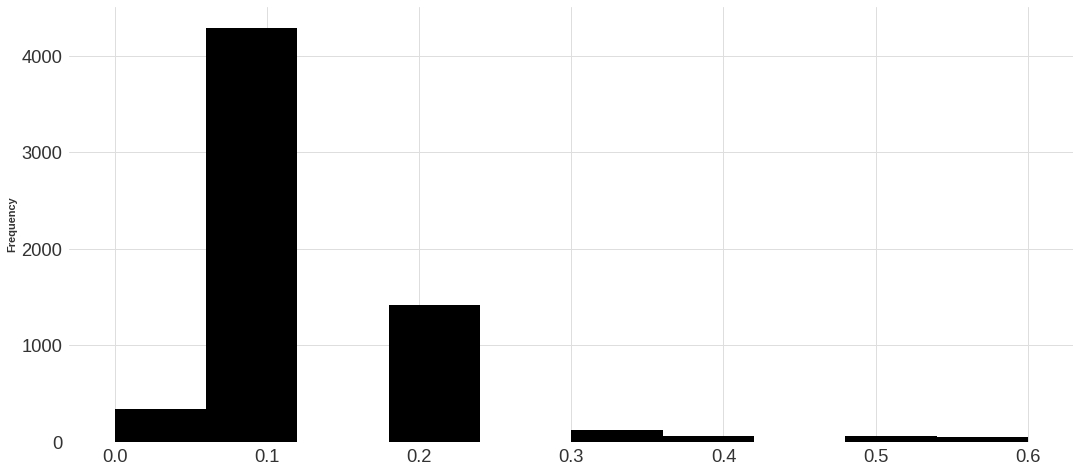

In [177]:
result_df['disount'].plot.hist()

In [178]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=True),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [179]:
eval_df[['rmse','rRMSE']] = eval_df[['rmse','rRMSE']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rRMSE']] = eval_df.groupby('model').mean()[['rmse','rRMSE']]

In [180]:
all_items_eval

value   sell_price  daily_revenue   disount  \
model                                                              
ARIMA         1.770995e+06  1412.556076   2.769256e+06  0.126409   
Fact          1.740323e+06  1412.556076   2.720469e+06  0.132707   
LGBM          1.736920e+06  1412.556076   2.715990e+06  0.130166   
Naive weekly  1.742047e+06  1412.556076   2.723214e+06  0.133481   
RF            1.741164e+06  1412.556076   2.722242e+06  0.132597   
Regression    1.740886e+06  1412.556076   2.721372e+06  0.134254   
Theta         1.736061e+06  1412.556076   2.714229e+06  0.127403   

              sell_price_w_disount  value_increase  value_w_disount  \
model                                                                 
ARIMA                  1234.038608           343.2     2.438291e+06   
Fact                   1224.912804           360.3     2.427840e+06   
LGBM                   1228.673367           353.4     2.407125e+06   
Naive weekly           1224.147506           362.4     2.437744e+06   
RF                     1225.304013           360.0     2.436161e+06   
Regression             1222.999304           364.5     2.444248e+06   
Theta                  1232.538994           345.9     2.397337e+06   

              daily_revenue_w_disount  daily_profit  daily_profit_w_disount  \
model                                                                         
ARIMA                    3.281454e+06  1.661554e+06            1.756613e+06   
Fact                     3.235723e+06  1.632281e+06            1.717366e+06   
LGBM                     3.227597e+06  1.629594e+06            1.722010e+06   
Naive weekly             3.254881e+06  1.633929e+06            1.730821e+06   
RF                       3.245726e+06  1.633345e+06            1.722283e+06   
Regression               3.247214e+06  1.632823e+06            1.719010e+06   
Theta                    3.221979e+06  1.628537e+06            1.722717e+06   

              value_fact  daily_profit_fact  value_w_disount_fact  \
model                                                               
ARIMA          1740323.0       1.632281e+06             2395292.9   
Fact           1740323.0       1.632281e+06             2427839.9   
LGBM           1740323.0       1.632281e+06             2414347.1   
Naive weekly   1740323.0       1.632281e+06             2432783.0   
RF             1740323.0       1.632281e+06             2433805.7   
Regression     1740323.0       1.632281e+06             2444497.7   
Theta          1740323.0       1.632281e+06             2404718.0   

              daily_profit_w_disount_fact  inventory_left  \
model                                                       
ARIMA                        1.725100e+06   286827.116298   
Fact                         1.717366e+06   242783.990000   
LGBM                         1.722931e+06   233490.081133   
Naive weekly                 1.729681e+06   248735.400000   
RF                           1.721610e+06   245970.869691   
Regression                   1.718175e+06   244175.627345   
Theta                        1.726926e+06   232353.238260   

              final_profit_w_discount  final_profit_base_price  \
model                                                            
ARIMA                    1.497817e+06             1.399761e+06   
Fact                     1.565530e+06             1.480446e+06   
LGBM                     1.500721e+06             1.401277e+06   
Naive weekly             1.505238e+06             1.400384e+06   
RF                       1.513439e+06             1.417830e+06   
Regression               1.517736e+06             1.426317e+06   
Theta                    1.513300e+06             1.411261e+06   

              profit_increase_%     rmse     rRMSE  
model                                               
ARIMA                  0.011734  218.250  0.937988  
Fact                   0.057472    0.000  0.000000  
LGBM                   0.013696  237.250  1.028320  
Naive weekly           0

In [181]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rRMSE:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + chart.transform_loess('rRMSE:Q', 'profit_increase_%:Q', bandwidth=.99).mark_line()

alt.LayerChart(...)

In [182]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

alt.Chart(...)

In [183]:
all_items_eval

value   sell_price  daily_revenue   disount  \
model                                                              
ARIMA         1.770995e+06  1412.556076   2.769256e+06  0.126409   
Fact          1.740323e+06  1412.556076   2.720469e+06  0.132707   
LGBM          1.736920e+06  1412.556076   2.715990e+06  0.130166   
Naive weekly  1.742047e+06  1412.556076   2.723214e+06  0.133481   
RF            1.741164e+06  1412.556076   2.722242e+06  0.132597   
Regression    1.740886e+06  1412.556076   2.721372e+06  0.134254   
Theta         1.736061e+06  1412.556076   2.714229e+06  0.127403   

              sell_price_w_disount  value_increase  value_w_disount  \
model                                                                 
ARIMA                  1234.038608           343.2     2.438291e+06   
Fact                   1224.912804           360.3     2.427840e+06   
LGBM                   1228.673367           353.4     2.407125e+06   
Naive weekly           1224.147506           362.4     2.437744e+06   
RF                     1225.304013           360.0     2.436161e+06   
Regression             1222.999304           364.5     2.444248e+06   
Theta                  1232.538994           345.9     2.397337e+06   

              daily_revenue_w_disount  daily_profit  daily_profit_w_disount  \
model                                                                         
ARIMA                    3.281454e+06  1.661554e+06            1.756613e+06   
Fact                     3.235723e+06  1.632281e+06            1.717366e+06   
LGBM                     3.227597e+06  1.629594e+06            1.722010e+06   
Naive weekly             3.254881e+06  1.633929e+06            1.730821e+06   
RF                       3.245726e+06  1.633345e+06            1.722283e+06   
Regression               3.247214e+06  1.632823e+06            1.719010e+06   
Theta                    3.221979e+06  1.628537e+06            1.722717e+06   

              value_fact  daily_profit_fact  value_w_disount_fact  \
model                                                               
ARIMA          1740323.0       1.632281e+06             2395292.9   
Fact           1740323.0       1.632281e+06             2427839.9   
LGBM           1740323.0       1.632281e+06             2414347.1   
Naive weekly   1740323.0       1.632281e+06             2432783.0   
RF             1740323.0       1.632281e+06             2433805.7   
Regression     1740323.0       1.632281e+06             2444497.7   
Theta          1740323.0       1.632281e+06             2404718.0   

              daily_profit_w_disount_fact  inventory_left  \
model                                                       
ARIMA                        1.725100e+06   286827.116298   
Fact                         1.717366e+06   242783.990000   
LGBM                         1.722931e+06   233490.081133   
Naive weekly                 1.729681e+06   248735.400000   
RF                           1.721610e+06   245970.869691   
Regression                   1.718175e+06   244175.627345   
Theta                        1.726926e+06   232353.238260   

              final_profit_w_discount  final_profit_base_price  \
model                                                            
ARIMA                    1.497817e+06             1.399761e+06   
Fact                     1.565530e+06             1.480446e+06   
LGBM                     1.500721e+06             1.401277e+06   
Naive weekly             1.505238e+06             1.400384e+06   
RF                       1.513439e+06             1.417830e+06   
Regression               1.517736e+06             1.426317e+06   
Theta                    1.513300e+06             1.411261e+06   

              profit_increase_%     rmse     rRMSE  
model                                               
ARIMA                  0.011734  218.250  0.937988  
Fact                   0.057472    0.000  0.000000  
LGBM                   0.013696  237.250  1.028320  
Naive weekly           0